In [1]:
import requests
import pandas as pd
import numpy as np
import pandas_profiling as pp
from ratelimit import limits, RateLimitException, sleep_and_retry
from backoff import on_exception, expo
from local.config import core

ModuleNotFoundError: No module named 'local'

In [ ]:
# CORE API 3.0.0 BETA #

apikey = core.api_key

@sleep_and_retry
@limits(calls=4, period=110)
def query_api(query, scrollId=None):
    
    headers={"Authorization":"Bearer "+apikey}
    search_url = "https://api.core.ac.uk/v3/search/works"
    
    if not scrollId:
        response = requests.get(f"{search_url}?q={query}&limit=75&scroll=true",headers=headers)
    else:
        response = requests.get(f"{search_url}?q={query}&limit=75&scrollId={scrollId}",headers=headers)        
    
    headers = response.headers
    status_code = response.status_code
    print(f"Code: {status_code} | RateLimit: {headers['X-RateLimit-Remaining']} / {headers['X-RateLimit-Limit']} | Retry: {headers['X-RateLimit-Retry-After']}")
        
    hit = response.json()
    
    if "results" in hit:
        for element in hit["results"]: 
            if "fullText" in element:
                del element["fullText"]

    return hit, status_code

def scroll(query):
    allResults = []
    scrollId = None
    
    result, status_code = query_api(query)
    
    scrollId = result["scrollId"]
    totalHits = int(result["totalHits"])
    hitCount = int(result["offset"]) + int(result["limit"])
    allResults.append(result["results"])
    print(f"{hitCount} < {totalHits}")
    
    while (scrollId is not None) & (hitCount < totalHits):
        result, status_code = query_api(query, scrollId=scrollId)
        
        if "results" in result:
            scrollId = result["scrollId"]
            hitCount = hitCount + int(result["limit"])
            print(f"{hitCount} < {totalHits}")
            allResults.append(result["results"])
        elif status_code == 500:
            continue
        else:
            break
    
    return allResults

def clean_results(results):
    
    
    def parse_journal_name(row):
        for x in row:
            if len(x) > 0:
                return x["title"]
            else:
                return "N/A"

    def parse_identifiers(row):
        for x in row:
            if len(x) > 0:
                return x["identifiers"]
            else:
                return "N/A"
        
    def parse_identifiers_issn(row):
        id_array = []
        if row is not None:
            for x in row:
                if not x.startswith("issn"):
                    id_array.append(x)

            return id_array

    results = [item for sublist in results for item in sublist]

    keep_col = ["id","magId","oaiIds","doi","documentType","title","abstract","publisher","yearPublished","journals","dataProviders","identifiers","authors"]

    df = pd.DataFrame(results).loc[:,keep_col]
    df["lcase_ttl"] = df["title"].str.lower()
    df["abstract"] = df["abstract"].str.lower()
    df["publisher"] = df["publisher"].str.lower().apply(lambda x: x[1:-1] if x.startswith("'") & x.endswith("'") else x)
    df["pubyear"] = df["yearPublished"].fillna(0).astype(int)    
    df["documentType"] = df["documentType"].apply(lambda x: None if x == "" else x)
    
    df["journal_name"] = df["journals"].apply(lambda x: parse_journal_name(x))
    df["identifiers"] = df["journals"].apply(lambda x: parse_identifiers(x))
    df["issns"] = df["identifiers"].apply(lambda x: parse_identifiers_issn(x))
    
    df.drop(columns=["yearPublished","journals","identifiers","title"], inplace=True)
    
    return df

In [ ]:
q = '(("c02 capture and storage")+OR+("carbon capture and storage"))+(utili?ation+OR+usage)+yearPublished:2015'
q2_2015 = scroll(q)

In [ ]:
q_2021 = '(("c02 capture and storage")+OR+("carbon capture and storage"))+(utili?ation+OR+usage)+yearPublished:2021'
q2_2021 = scroll(q_2021)

In [ ]:
q_2022 = '(("c02 capture and storage")+OR+("carbon capture and storage"))+(utili?ation+OR+usage)+yearPublished:2022'
q2_2022 = scroll(q_2022)

In [15]:
#df_q2 = pd.concat([clean_results(q2_2015),clean_results(q2_2021),clean_results(q2_2022)], ignore_index=True)
df_q2 = pd.read_csv("../data/core_q2_results.csv").drop("Unnamed: 0", axis=1)

#dataProviders = df_q2["dataProviders"].explode("dataProviders").drop_duplicates()
#dataProviders.to_csv("local/dataProviders.csv")

<AxesSubplot:xlabel='Type'>

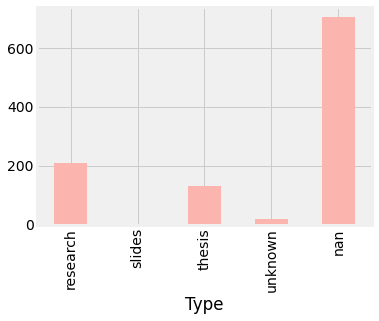

In [16]:
### Document Type Analysis ###
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
matplotlib.style.use('fivethirtyeight')
df_q2.groupby("documentType", dropna=False)["id"].agg("count").plot.bar(xlabel="Type", colormap="Pastel1")

In [17]:
df_q2_agg = df_q2.assign(has_abstract = df_q2["abstract"].apply(lambda x: (x is not None)))\
                .assign(has_journal_name = df_q2["journal_name"].apply(lambda x: (x is not None))) \
                .assign(has_issns = df_q2["issns"].apply(lambda x: (x is not None))) \
                .assign(has_doi = df_q2["doi"].apply(lambda x: (x is not None))) \
                .assign(has_publisher = df_q2["publisher"].apply(lambda x: (x is not None))) \
                .assign(row_count = True)

/tmp/ipykernel_4900/1267297884.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_docType = df_q2_agg.groupby(["pubyear","documentType"], dropna=False)["has_abstract","has_journal_name","has_issns","has_doi","has_publisher","row_count"]\


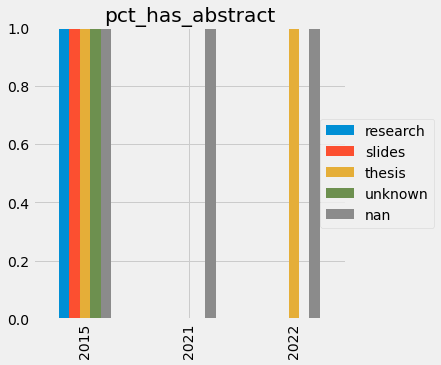

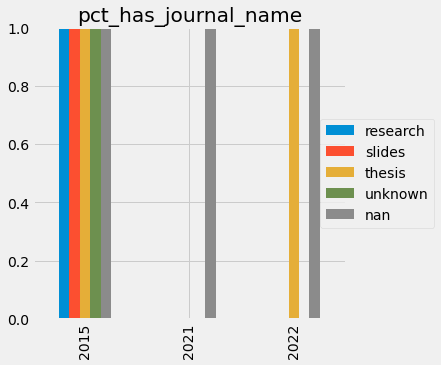

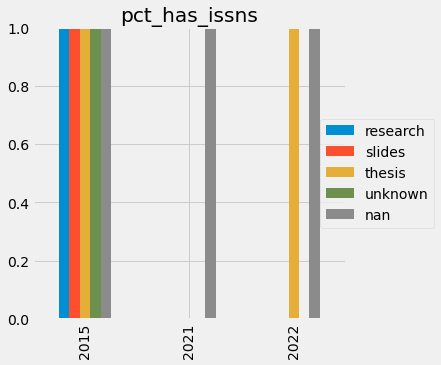

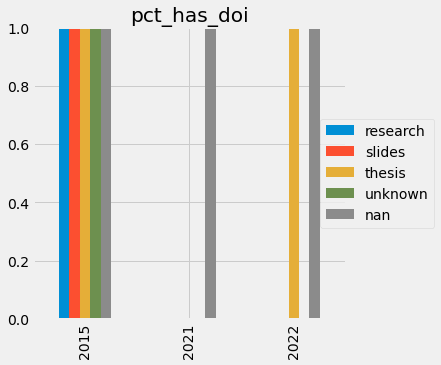

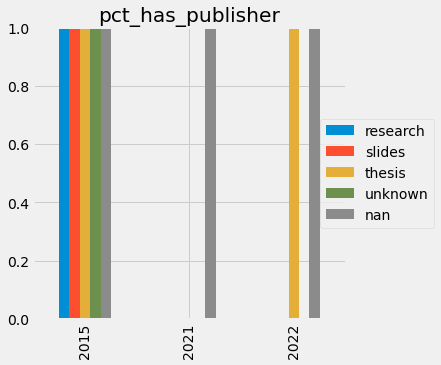

In [18]:
df_docType = df_q2_agg.groupby(["pubyear","documentType"], dropna=False)["has_abstract","has_journal_name","has_issns","has_doi","has_publisher","row_count"]\
                        .agg(np.sum)

for c in df_docType.columns:
    if c != "row_count":
        df_docType.assign(pct = df_docType[c]/df_docType["row_count"])\
          .loc[:,"pct"].unstack().plot.bar(figsize=(5,5), title=f"pct_{c}", xlabel="", ylim=(0,1))
        plt.legend(loc="center", bbox_to_anchor=(1.1,0.5),ncol=1, fancybox=True)